# Exercise Session 5: Logistic Regression

$\renewcommand{\real}{\mathbb{R}}$
$\renewcommand{\xb}{\mathbf{x}}$
$\renewcommand{\wb}{\mathbf{w}}$
$\renewcommand{\Xb}{\mathbf{X}}$
$\renewcommand{\yb}{\mathbf{y}}$
$\renewcommand{\Yb}{\mathbf{Y}}$
$\DeclareMathOperator*{\argmin}{argmin}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# project files
import sys
sys.path.append('..')
import hw_05.helpers as helpers

# 3rd party
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# 1 Introduction
This week's exercise is about linear classifically, or more specifically, logistic regression. You will see both the binary and the multi-class variant of the logistic regression.

# 2 Binary Class Logistic Regression

Let's start by loading the [_Iris Flower Dataset_](https://en.wikipedia.org/wiki/Iris_flower_data_set). Since our topic is linear classification, we will only use 2 out of 4 features of this dataset. For the first part we will use 2 out of 3 classes (named as *setosa* and *versicolor*). Later on, we will also use the third class *virginica*.
Therefore, for this part our dataset with two classes is as follows:

  - data: $\Xb \in \real^{N \times 3}$, $\forall \xb_i \in \Xb: \xb_i \in \real^{3}$ (2 features and the bias)
  - labels: $\yb \in \real^{N}$, $\forall y_i \in \yb: y_i \in \{0, 1\}$ 

Note that $\Xb$ is a matrix of shape $(N \times D)$. However, a single data sample $\xb_i$ is a column vector of shape $(D \times 1)$. 
When you want to perform a scalar product of one data sample with the weights vector $\wb$ (also a column vector of shape $(D \times 1)$) you will see: $\xb_i^\top\cdot\wb$. When you want to perform matrix-vector multiplication of the entire data matrix with the weights vector, you will see: $\Xb\cdot\wb$.

<IPython.core.display.Javascript object>


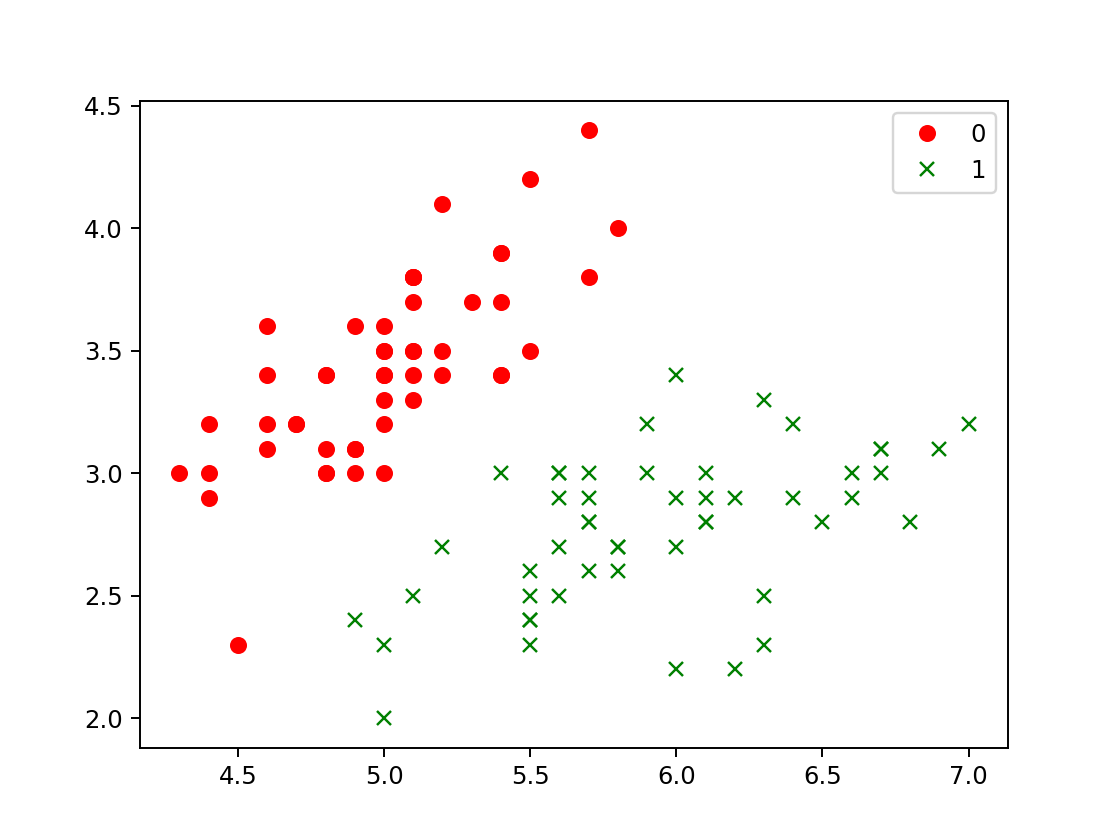

In [2]:
# Loads the data and split them into trian and test subsets.
data, labels = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False,
                              setosa=True, versicolor=True, virginica=False, addbias=True)
fig = helpers.scatter2d_multiclass(data, labels)

num_samples = data.shape[0]

fraction_train = 0.8
np.random.seed(0)
rinds = np.random.permutation(num_samples)

data_train = data[rinds[:int(num_samples * fraction_train)]] 
labels_train = labels[rinds[:int(num_samples * fraction_train)]]  

data_test = data[rinds[int(num_samples * fraction_train):]] 
labels_test = labels[rinds[int(num_samples * fraction_train):]]  

## 2.1 A short introduction

In logistic regression, the probability of a datapoint belonging to a class is found as:
$$P(y_i=1|\xb_i, \wb) = \frac{1}{1+e^{-\xb_i^{\top}\cdot \wb}} $$

This is called the sigmoid function! The sigmoid function is defined as:
$$\sigma(t)= \frac{1}{1+e^{-t}}$$

So in our case, our model is defined as:
$$\hat{y}(\xb_i)=\sigma(\xb_i^{\top}\cdot \wb)= \frac{1}{1+e^{-\xb_i^{\top}\cdot \wb}}$$



Let's try to code this function. You can use the numpy function `np.exp(x)` to take the exponential of a number.

In [3]:
def sigmoid(t):
    """ Sigmoid function
    
    Args:
        t (np.array): Input data of shape (N, )
        
    Returns:
        np.array: Probabilites of shape (N, ), where each value is in {0, 1}.
    """
    return 1/(1+np.exp(-t))

Recall that the cross entropy loss is defined as:
$$
R(\wb) = -\sum_i (y_i \log(\hat{y}(\xb_i)) + (1-y_i)\log(1-\hat{y}(\xb_i))) $$


In [4]:
def loss_logistic(data, labels, w): 
    """ Logistic regression loss function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        int: Loss of logistic regression.
    """
    labels_pred = [sigmoid(x) for x in np.dot(data, w)]
    loss_sum = 0.0
    for i in range(len(data)):
      loss_sum += labels[i] * np.log(labels_pred[i]) + (1-labels[i]) * np.log(1-labels_pred[i]) 
    return -loss_sum

We need to find the gradient of the loss function in order to move our weights towards the optimal weights. The gradient of the loss function is:
$$\nabla R(\wb)= \sum_i (\hat{y}(\xb_i) - y_i)\xb_i $$
Let us put this into nice matrix format:
$$\nabla R(\wb)= \Xb^\top(\hat{y}(\Xb) - \yb) = \Xb^\top(\sigma(\Xb\cdot \wb) - \yb),
$$

where $\hat{y}(\Xb) = \sigma(\Xb\cdot \wb)$ and $\sigma(\Xb\cdot \wb)$ computes the sigmoid for each data sample separately, and returns a vector of shape $(N \times 1)$.

Fill in the function for finding the gradient `gradient_logistic()`. You can use the numpy function `np.dot()` or an operator `@` for matrix multiplication.

In [5]:
def gradient_logistic(data, labels, w):
    """ Logistic regression gradient function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        np. array: Gradient array of shape (D, )
    """

  
    return np.transpose(data) @ (sigmoid(data @ w)-labels)

## 2.2 Classifying using a logistic regression model

Now let us write a function to perform classification using logistic regression, `logistic_regression_classify()`. This function uses the weights we find during training in order to predict the labels for the data.

**Hints:**
* We classify our data according to $P(y_i=1|\xb_i, \wb)$. If the value of $P(y_i=1|\xb_i, \wb)$ is less than 0.5 then the data point is classified as label 0. If it is more than or equal to 0.5 then we classify the data point as label 1.

In [6]:
def logistic_regression_classify(data, w):
    """ Classification function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        np.array: Label assignments of data of shape (N, )
    """
    #### write your code here: find predictions and threshold them.
    predictions = sigmoid(data @ w)
    predictions = [1 if prediction>0.5 else 0 for prediction in predictions]
    
    return predictions

Let us also write an `accuracy()` function defined as the following:
$$ f_{\text{acc}} = \frac{\text{# correct predictions}}{\text{# all predictions}}$$

In [7]:
def accuracy(labels_gt, labels_pred):
    """ Computes accuracy.
    
    Args:
        labels_gt (np.array): GT labels of shape (N, ).
        labels_pred (np.array): Predicted labels of shape (N, ).
        
    Returns:
        float: Accuracy, in range [0, 1].
    """
    valid_prediction_count = 0
    for pred, value in zip(labels_gt, labels_pred):
      valid_prediction_count += (pred == value)
    
    return valid_prediction_count / len(labels_gt)

## 2.3 Training a logistic regression model

In order to find good weights and have a high accuracy we need to train our model. Fill in missing parts of the function `logistic_regression_train()`.

The function first initializes the weights according to a gaussian distribution. In each iteration, you should find the gradient using `gradient_logistic` and take a gradient step using these weights. Given that $\eta$ is the learning rate, recall that a gradient step is: $$ \wb^{[t + 1]}  = \wb^{[t]} - \eta \nabla R(\wb^{[t]}) $$

The `loss`, `plot` and `print_every` parameters affect the way the loss is printed and the predictions are displayed. You do not need to modify these parts.


In [8]:
def logistic_regression_train(data, labels, max_iters=10, lr=0.001, 
                              print_period=100, plot_period=1000):
    """ Training function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        max_iters (integer): Maximum number of iterations. Default:10
        lr (integer): The learning rate of  the gradient step. Default:0.001
        print_period (int): Num. iterations to print current loss. 
            If 0, never printed.
        plot_period (int): Num. iterations to plot current predictions.
            If 0, never plotted.
    Returns:
        np.array: weights of shape(D, )
    """
    #initialize weights randomly according to gaussian distribution
    weights = np.random.normal(0., 0.1, [data.shape[1],])
    for it in range(max_iters):
        ########## write your code here: find gradient and do a gradient step
        gradient = gradient_logistic(data, labels, weights)
        weights = weights - (lr * gradient)
        ##################################
        predictions = logistic_regression_classify(data, weights)
        if print_period and it % print_period == 0:
                print('loss at iteration', it, ":", loss_logistic(data, labels, weights))
        if plot_period and it % plot_period == 0:
            fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions)
            plt.title("iteration "+ str(it))
        if accuracy(labels, predictions) == 1:
            break
    fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions)
    plt.title("iteration "+ str(it))
    return weights

Run the code below to see your training in action. What do you observe? Try playing with the learning rate and number of max iterations.

loss at iteration 0 : 118.30493821407718


<IPython.core.display.Javascript object>


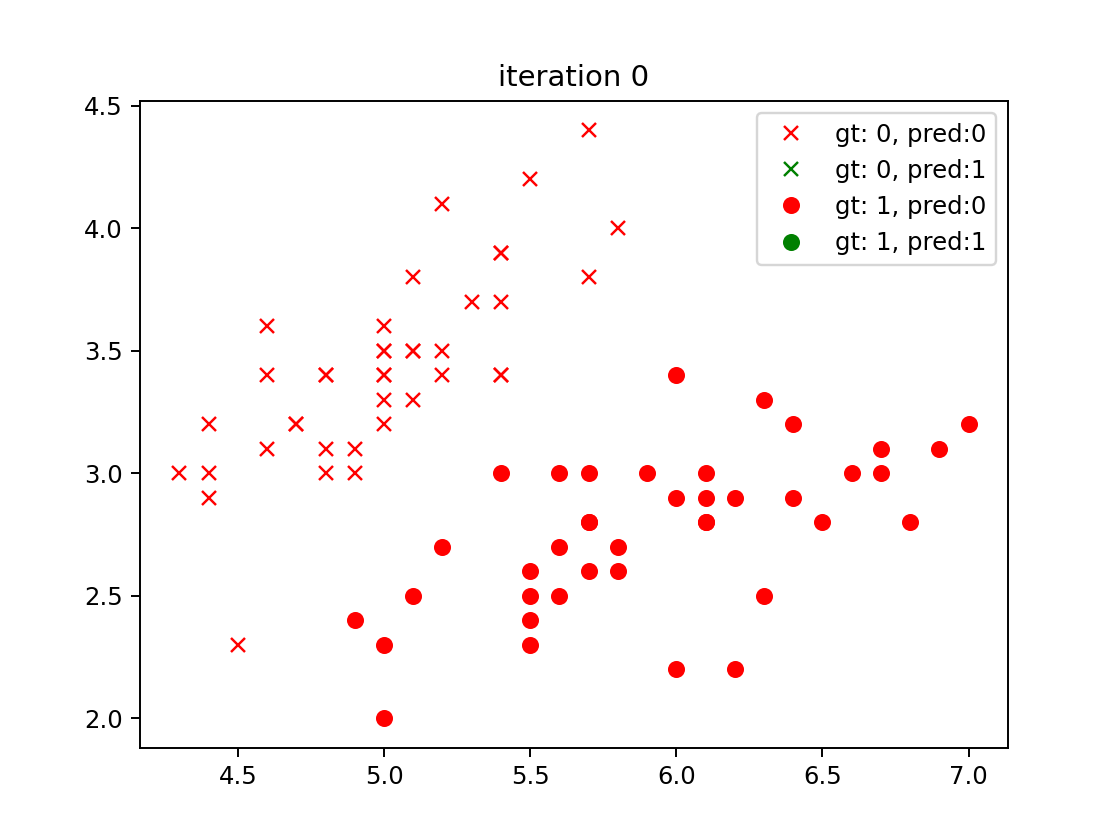

loss at iteration 50 : 5.105675414275735
loss at iteration 100 : 4.869906599863517
loss at iteration 150 : 4.782551799857658
loss at iteration 200 : 4.704680164809081


<IPython.core.display.Javascript object>


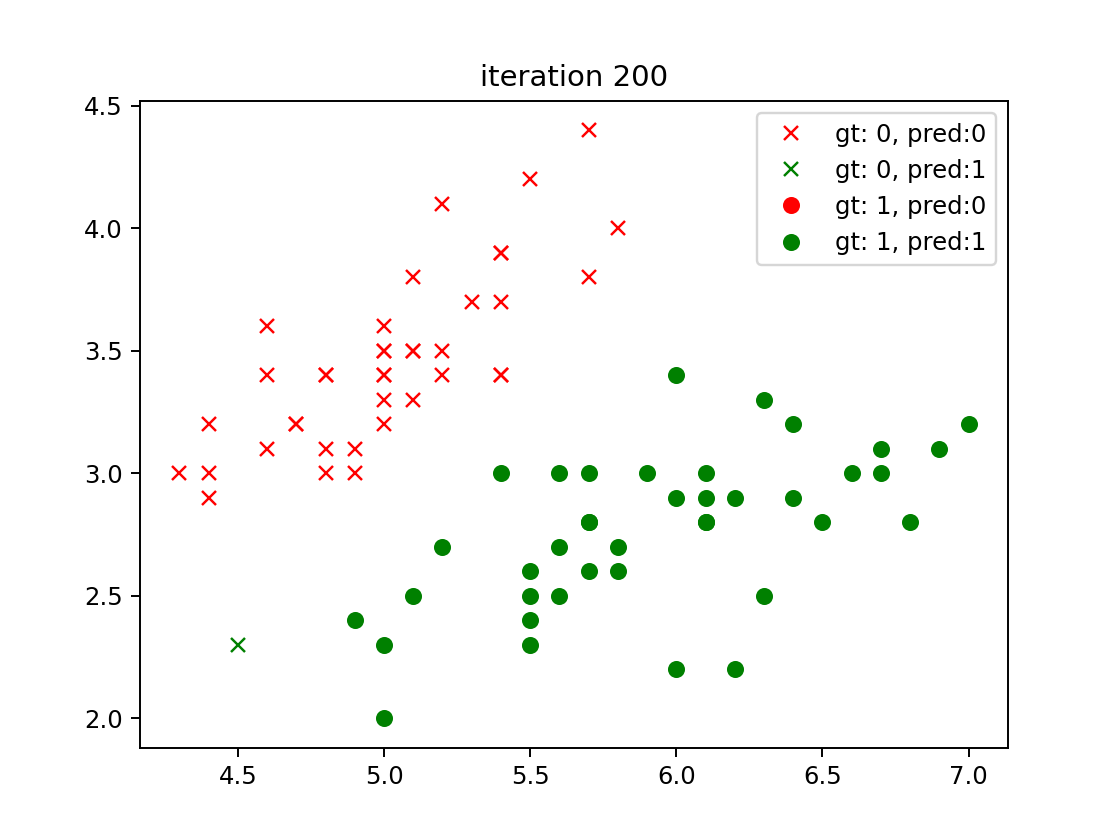

In [9]:
weights = logistic_regression_train(data_train, labels_train, max_iters=201, lr=1e-2, print_period=50, plot_period=3000)

<IPython.core.display.Javascript object>


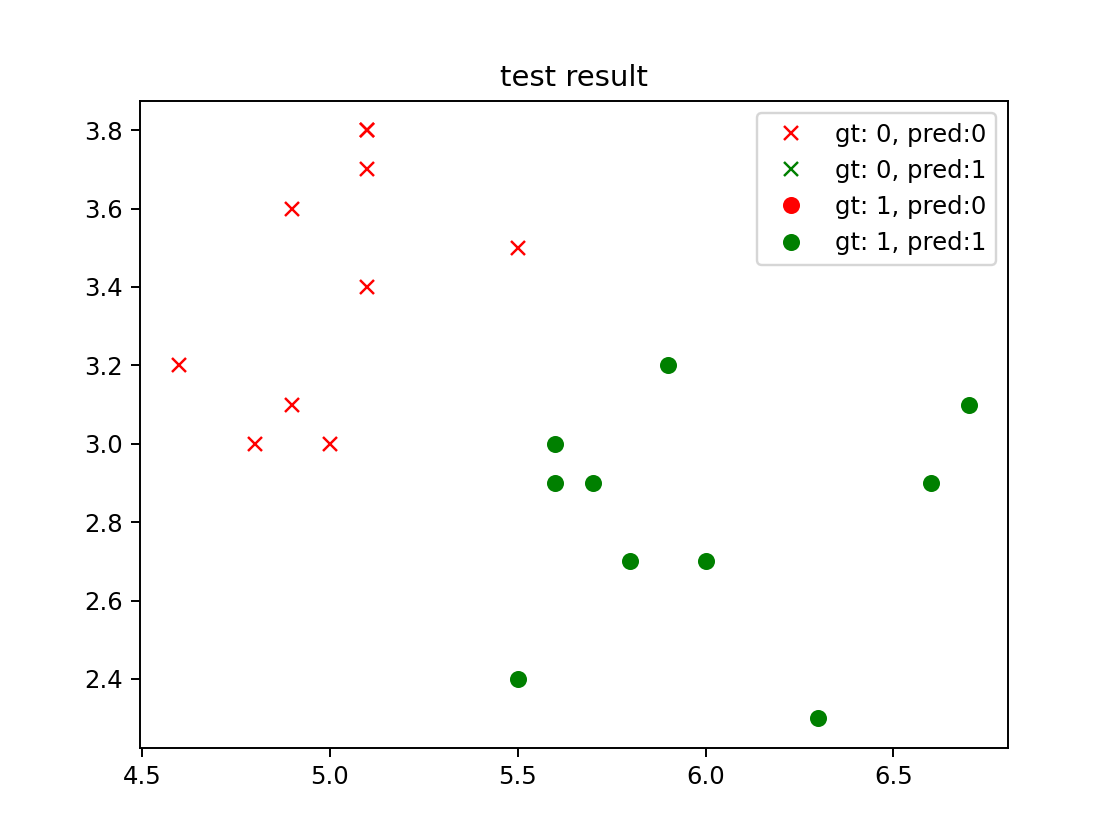

Accuracy is 1.0


In [10]:
predictions = logistic_regression_classify(data_test, weights)
fig = helpers.visualize_predictions(data=data_test, labels_gt=labels_test, labels_pred=predictions)
plt.title("test result")
print("Accuracy is", accuracy(labels_test, predictions))

Now that we have classified two classes, we can move on to multi-class logistic regression.

# 3 Multi-Class Logistic Regression

Load the synthetic data by running the code segment below. We will use this dataset for now as it is easy to work with.
Our data is:

 - data: $\Xb \in \real^{N \times 3}$, $\forall \xb_i \in \Xb: \xb_i \in \real^{3}$ (2 features + the bias)
 - labels: $\Yb \in \real^{N \times C}$, $\forall \yb_i \in \Yb: \yb_i$  is a one-hot encoding of the label of a data sample, e.g. $\yb_i = [0, 0, 1]$ if $\xb_i$ is class $2$. $C$ is number of classes.

<IPython.core.display.Javascript object>


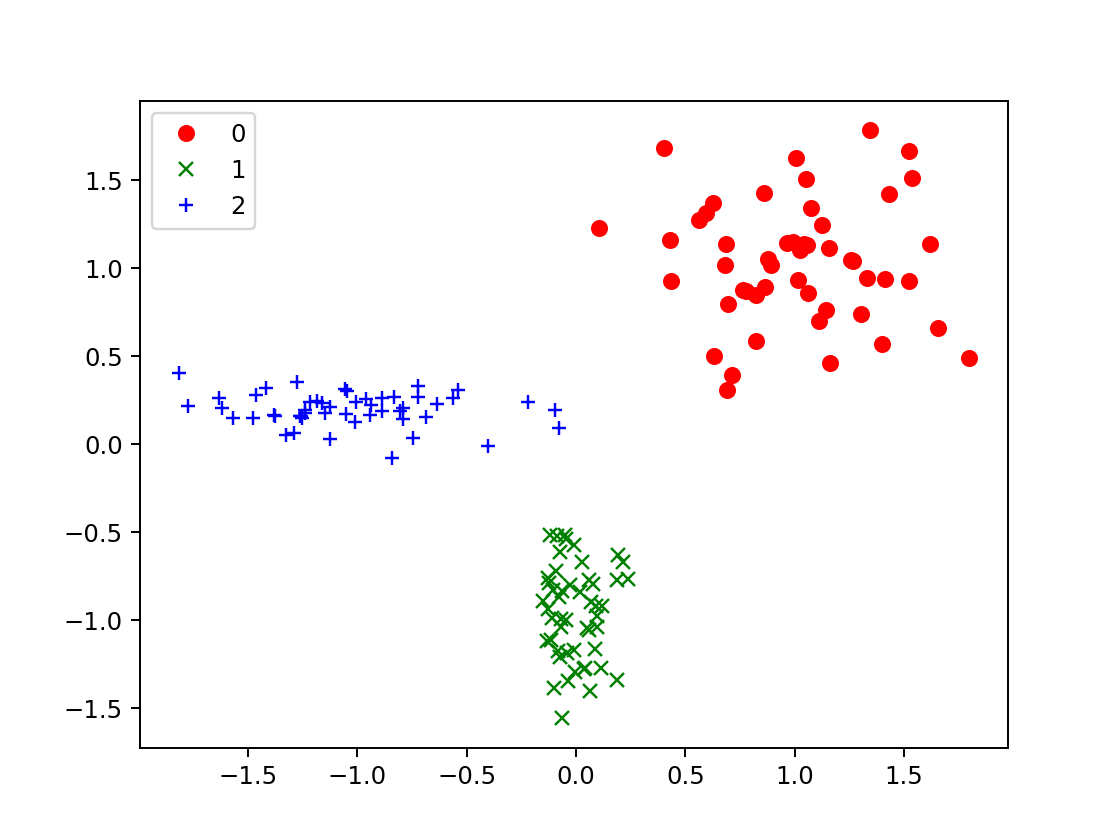

In [11]:
data_multi, labels_multi = helpers.load_dataset_synth(addbias=True)
fig = helpers.scatter2d_multiclass(data_multi, helpers.onehot_to_label(labels_multi), fig=None, fig_size=None, color_map=None,
                         legend=True, legend_map=None, grid=False, show=False)

num_samples = data_multi.shape[0]

fraction_train = 0.8
np.random.seed(0)
rinds = np.random.permutation(num_samples)
data_train = data_multi[rinds[:int(num_samples * fraction_train)]] 
labels_train = labels_multi[rinds[:int(num_samples * fraction_train)]]  

data_test = data_multi[rinds[int(num_samples * fraction_train):]] 
labels_test= labels_multi[rinds[int(num_samples * fraction_train):]]  

## 3.1 A short introduction 

Multi class logistic regression is an extention to binary logistic regression.

Let us consider logistic regression for C classes. We keep our weights in a weight matrix $\mathbf{W}$, where every column is $\wb_{(k)}$ for class $k$. Therefore, for every class $k$, we learn a separate $\wb_{(k)}$ during training. The weights matrix will be of size $(3 \times C)$.

The generalized probabilities for logistic regression is
$$\hat{y}^{(k)}(\xb_i) = P(y_i=k|\xb_i, \mathbf{W}) = \frac{e^{\xb_i^\top\cdot \wb_{(k)}}}{\sum_j^C e^{\xb_i^\top\cdot \wb_{(j)}}}$$ 
which is called the softmax function! Let us denote this function by $f_\text{softmax}$.

Fill in the implementation of this function below. It is used to assign the probabilities of a datapoint belonging to each class. For example, for a single datapoint, for 3 classes you might have the following probability assignments {0.2, 0.7, 0.1}. The probabilities all sum up to 1. 


In [12]:
def f_softmax(data, w):
    """ Softmax function
    
    Args:
        data (np.array): Input data of shape (N, D)
        w (np.array): Weights of shape (D, C) where C is # of classes
        
    Returns:
        np.array: Probabilites of shape (N, C), where each value is in 
            range [0, 1] and each row sums to 1.
    """
    
    #data.shape[0] is the number of datapoints, and w.shape[1] is the number of classes.
    res = np.zeros([data.shape[0], w.shape[1]]) 
    #The normalization term only has to be calculated once for all classes
    norm = np.sum(np.exp(data@w), axis=1)
    #We iterate for each class
    for k in range(w.shape[1]):
        exp_top = np.exp(data@w[:, k])
        res[:, k] = exp_top/norm
    return res

Using these, we find the loss function which we are trying to minimize is

$$R(\mathbf{W}) = -\sum_{i}^N\sum_{k}^Cy_i^{(k)}\log(\hat{y}^{(k)}(\xb_i)) \\
=-\sum_{i}^N\sum_{k}^Cy_i^{(k)}\log(f_\text{softmax}(\xb_{i}^\top \cdot \wb_{(k)}))$$ 

Fill in the loss function below.

In [13]:
def loss_logistic_multi(data, labels, w):
    """ Loss function for multi class logistic regression
    
    Args:
        data (np.array): Input data of shape (N, D)
        labels (np.array): Labels of shape  (N, )
        w (np.array): Weights of shape (D, C)
        
    Returns:
        int: Loss value 
    """
    
    res = f_softmax(data, w)
    
    loss = 0
    
    for res_p, label_p, in zip(res, labels):
        for res_p_k, label_p_k in zip(res_p, label_p):
            loss += label_p_k * np.log(res_p_k)
    return -loss

To find the gradient, we find the gradient of $R(\mathbf{W})$ with respect to the weights $\wb$. We have
$$\nabla R(\mathbf{W})=\sum_i^N\xb_{i}(\hat{\yb}(\xb_i)-y_i)^\top$$
Let's put this into matrix format as well:
$$\nabla R(\mathbf{W})= \Xb^T(\hat{\yb}(\Xb) - \Yb)$$

A note on the notation:
Here, $\hat{\yb}(\xb_i)$ returns the softmax result of shape $(C \times 1)$ for sample $\xb_i$ for all classes. 

$\hat{\yb}(\Xb)$ should return a matrix of shape $(N\times C)$, which consists of the softmax predictions for every sample for all classes. (Each row of $\hat{\yb}(\Xb)$ is $\hat{\yb}(\xb_i)$.)


Now, you will fill in the gradient function, `gradient_logistic_multi()` given below. 


In [14]:
def gradient_logistic_multi(data, labels, w):
    """ Gradient function for multi class logistic regression
    
    Args:
        data (np.array): Input data of shape (N, D)
        labels (np.array): Labels of shape  (N, )
        w (np.array): Weights of shape (D, C)
        
    Returns:
        np.array: Gradients of shape (D, C)
    """
    res = f_softmax(data, w)
    grad_w = data.T @ (res - labels)
    
    return grad_w

## 3.2 Classification and training for multiple classes

Write the functions for classification and training.

Hints:
* For the classification function, you will be using $f_\text{softmax}$ to assign the probabilities of a datapoint belonging to each class. The softmax function returns an array of size $(N \times C)$.
* You will have to convert one-hot representation to labels (`np.argmax` is your friend). 

* Training will be the same as the binary case. First, we will find the gradient. Then we will update the weights using gradient descent.

In [15]:
def logistic_regression_classify_multi(data, w):
    """ Classification function for multi class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        w (np.array): Weights of logistic regression model of shape (D, C)
    Returns:
        np. array: Label assignments of data of shape (N, ).
    """
    #### write your code here: find predictions, argmax to find the correct label
    predictions = [np.argmax(data_n) for data_n in f_softmax(data, w)]
    
    return predictions

In [24]:
def logistic_regression_train_multi(data, labels, k=3, max_iters=10, lr=0.001, 
                                    print_period=5, plot_period=5):
    """ Classification function for multi class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, )
        k (integer): Number of classes. Default=3
        max_iters (integer): Maximum number of iterations. Default:10
        lr (integer): The learning rate of  the gradient step. Default:0.001
        print_period (int): Num. iterations to print current loss. 
            If 0, never printed.
        plot_period (int): Num. iterations to plot current predictions.
            If 0, never plotted.
    Returns:
        np. array: Label assignments of data of shape (N, ).
    """
    weights = np.random.normal(0, 0.1, [data.shape[1], k])
    for it in range(max_iters):
        ############### YOUR CODE HERE
        gradient = gradient_logistic_multi(data, labels, weights)
        weights = weights - lr*gradient
        ##################################
        predictions = logistic_regression_classify_multi(data, weights)
        if print_period and it % print_period == 0:
            print('loss at iteration', it, ":", loss_logistic_multi(data, labels, weights))
        if plot_period and it % plot_period == 0:
            fig = helpers.visualize_predictions(data=data, labels_gt=helpers.onehot_to_label(labels), labels_pred=predictions)
            plt.title("iteration "+ str(it))
        if accuracy(helpers.onehot_to_label(labels), predictions) == 1:
            break
    fig = helpers.visualize_predictions(data=data, labels_gt=helpers.onehot_to_label(labels), labels_pred=predictions)
    plt.title("iteration "+ str(it))
    return weights

0
loss at iteration 0 : 123.98151855020708


<IPython.core.display.Javascript object>


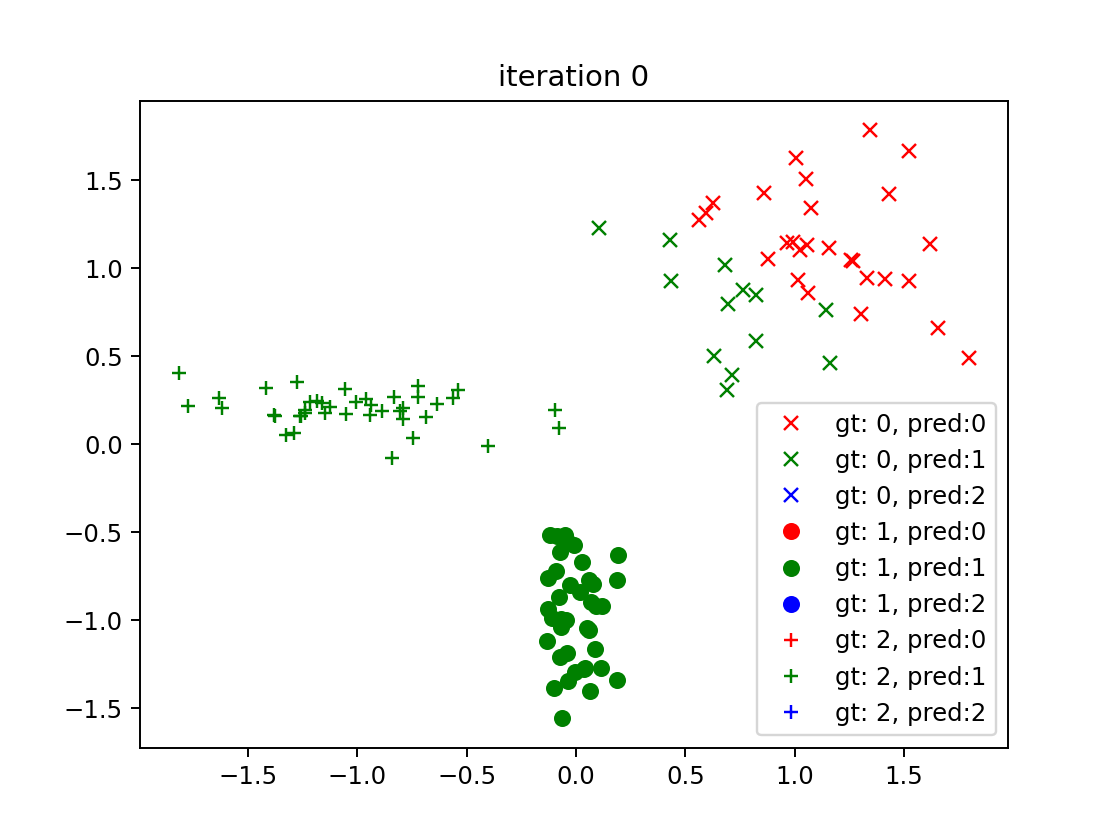

1
loss at iteration 1 : 118.10238893438039
2
loss at iteration 2 : 112.63810905414717
3
loss at iteration 3 : 107.5640655646981
4
loss at iteration 4 : 102.85436561309919
5
loss at iteration 5 : 98.48271657864362
6
loss at iteration 6 : 94.42315890662238
7
loss at iteration 7 : 90.65062779319061
8
loss at iteration 8 : 87.14134617648172
9
loss at iteration 9 : 83.87306866132923


<IPython.core.display.Javascript object>


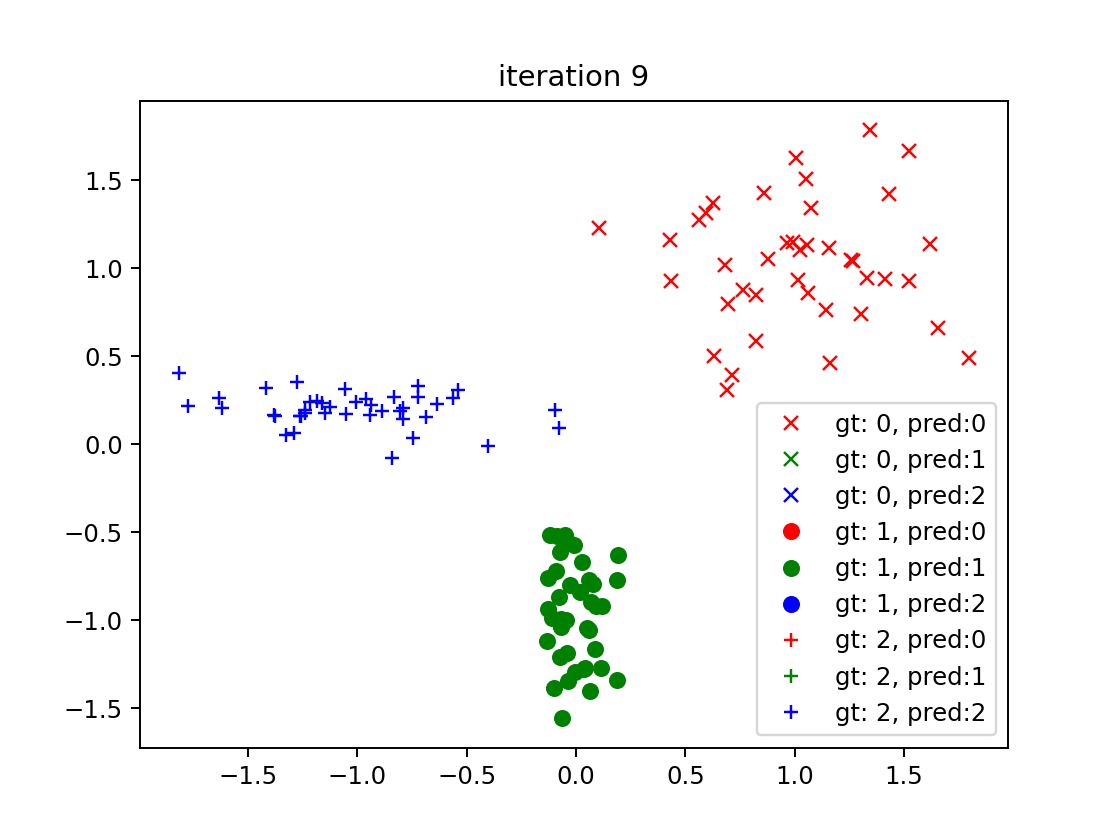

In [17]:
weights_multi = logistic_regression_train_multi(data_train, labels_train, max_iters=101, lr=1e-3, print_period=1, plot_period=100)

<IPython.core.display.Javascript object>


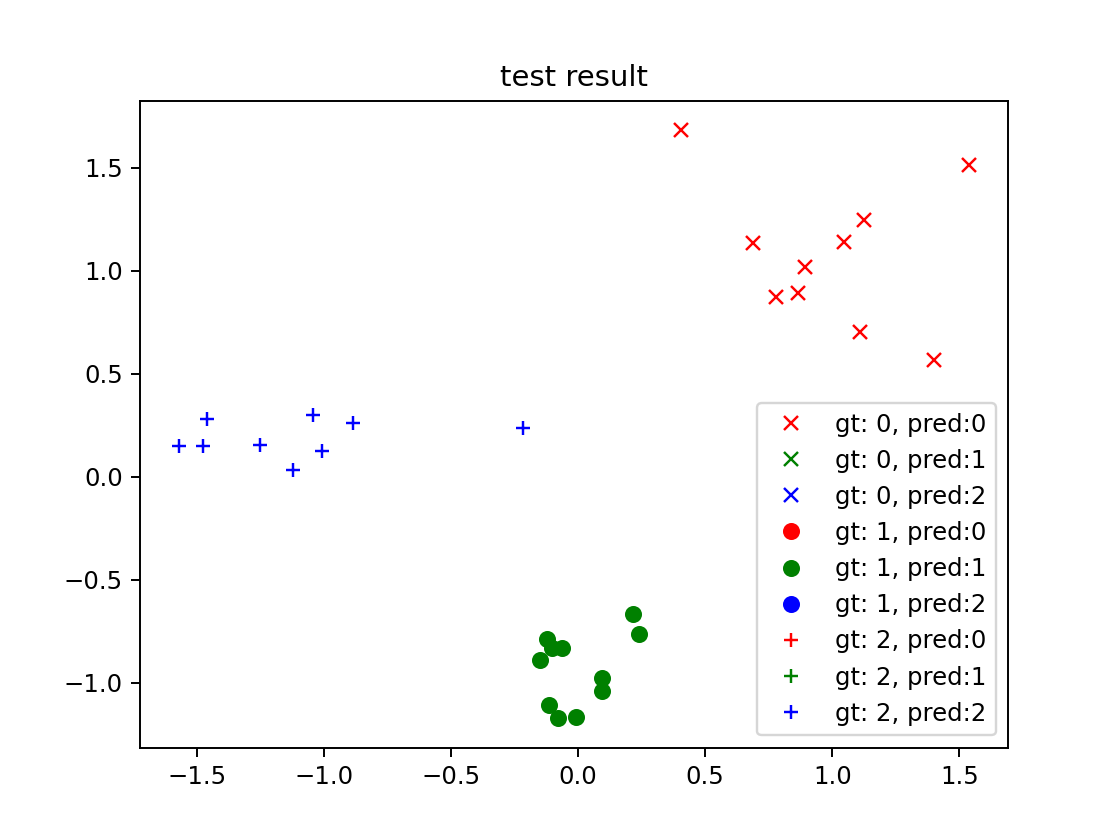

Accuracy is 1.0


In [18]:
predictions_multi = logistic_regression_classify_multi(data_test, weights_multi)
fig = helpers.visualize_predictions(data=data_test, labels_gt=helpers.onehot_to_label(labels_test), labels_pred=predictions_multi)
plt.title("test result")
print("Accuracy is", accuracy(helpers.onehot_to_label(labels_test), predictions_multi))

**A side note:** Notice that using this simple formulation, we have trained C classifiers for C classes.
Our probability assignments are according to the softmax function.
$$P(\yb_i=k|\xb_i, \mathbf{W}) = \frac{e^{\xb_i^\top\cdot \wb_{(k)}}}{\sum_j^C e^{\xb_i^\top\cdot \wb_{(j)}}}$$
And $$\sum_{k}^{C}P(\yb_i=k|\xb_i, \mathbf{W})=1$$
However, in the binary case we were training 1 classifier for 2 classes. The probabilities are assigned according to the sigmoid function.
$$P(\yb_i=1|\xb_i, \wb) = \frac{1}{1+e^{-(\xb_i^\top\cdot \wb)}} \\
P(\yb_i=0|\xb_i, \wb) = 1-P(\yb_i=1|\xb_i, \wb) = \frac{1}{1+e^{(\xb_i^\top\cdot \wb)}}$$

Similar to the binary case, we can train C-1 classifiers for C classes. We modify the probability assignment function to be, for classes $k={1, ... ,C-1}$.
$$P(\yb_i=k|\xb_i, \mathbf{W}) = \frac{e^{\xb_i^\top\cdot \wb_{(k)}}}{1+\sum_j^{C-1} e^{\xb_i^\top\cdot \wb_{(j)}}}$$

**Q:** What is $P(\yb_n=C|\xb_i, \mathbf{W})$?

## 3.3 Test on the Iris dataset

Now let us  test our code on the iris dataset. We load and display the dataset below. 

<IPython.core.display.Javascript object>


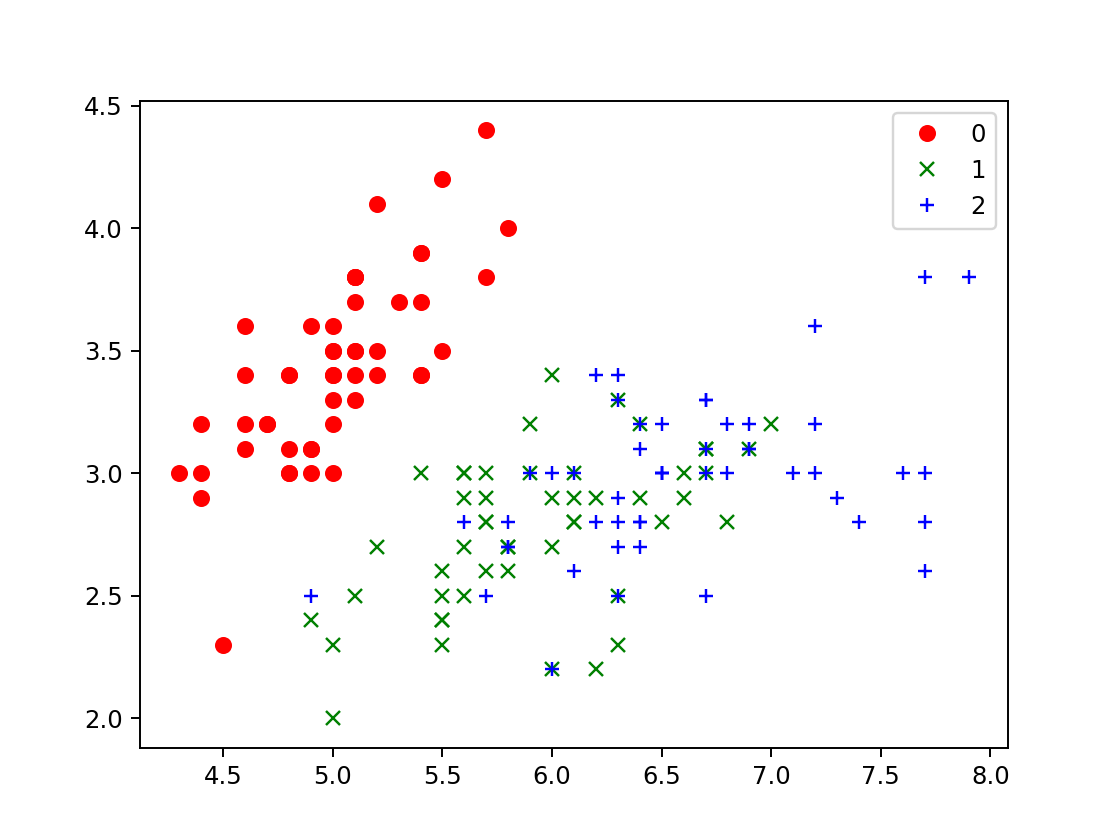

In [25]:
data_multi, labels_multi = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False, setosa=True, versicolor=True, virginica=True, addbias=True)
labels_multi = helpers.label_to_onehot(labels_multi)
fig = helpers.scatter2d_multiclass(data_multi, helpers.onehot_to_label(labels_multi), fig=None, fig_size=None, color_map=None,
                         legend=True, legend_map=None, grid=False, show=False)

num_samples = data_multi.shape[0]

fraction_train = 0.8
np.random.seed(0)
rinds = np.random.permutation(num_samples)
data_train = data_multi[rinds[:int(num_samples * fraction_train)]] 
labels_train = labels_multi[rinds[:int(num_samples * fraction_train)]]  

data_test = data_multi[rinds[int(num_samples * fraction_train):]] 
labels_test= labels_multi[rinds[int(num_samples * fraction_train):]]  

loss at iteration 0 : 139.4724686541573


<IPython.core.display.Javascript object>


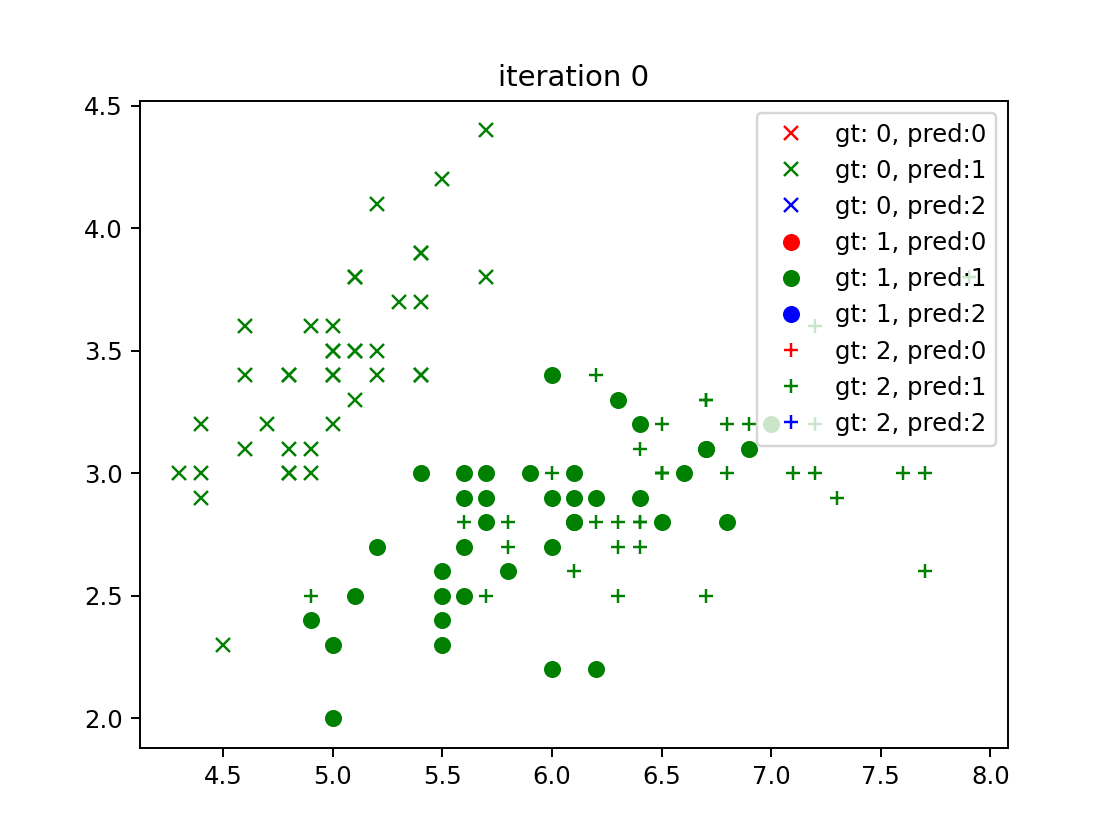

loss at iteration 500 : 62.61414306610337
loss at iteration 1000 : 57.91506214764736
loss at iteration 1500 : 55.69565864738949
loss at iteration 2000 : 54.331102610110065


<IPython.core.display.Javascript object>


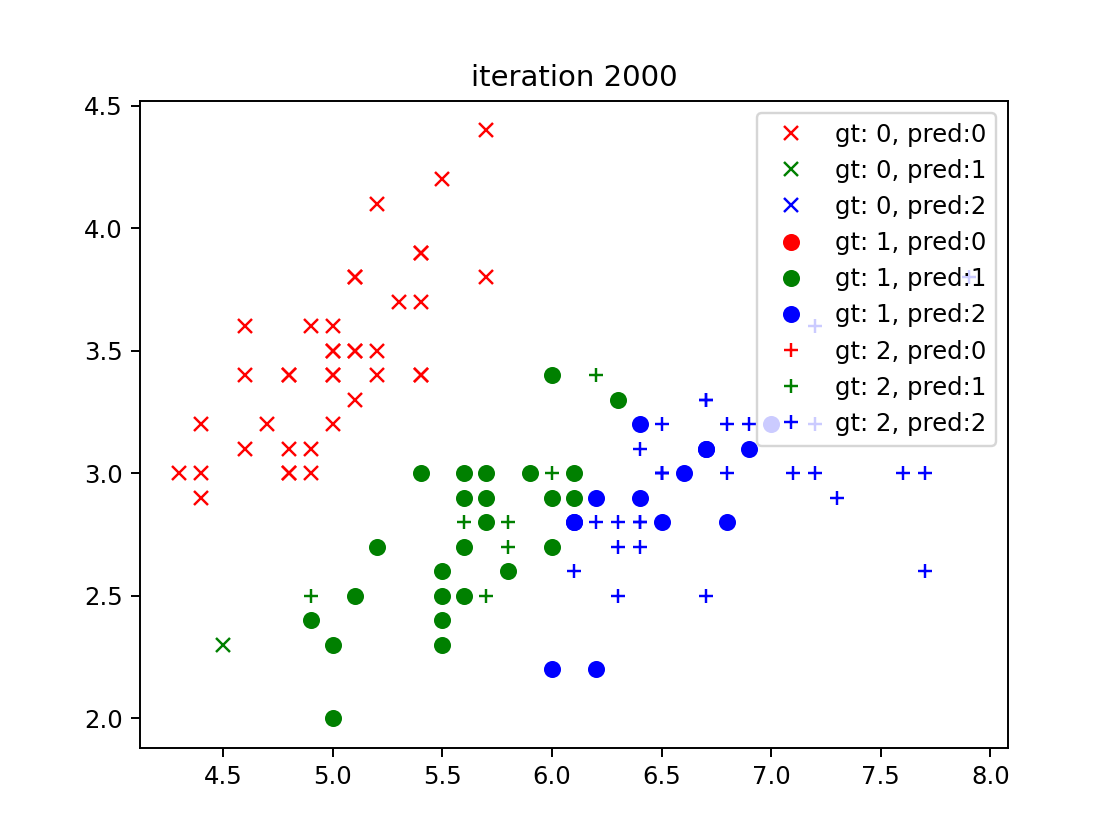

loss at iteration 2500 : 53.39986253875547
loss at iteration 3000 : 52.72660867879449
loss at iteration 3500 : 52.2205544927127
loss at iteration 4000 : 51.82867910066774


<IPython.core.display.Javascript object>


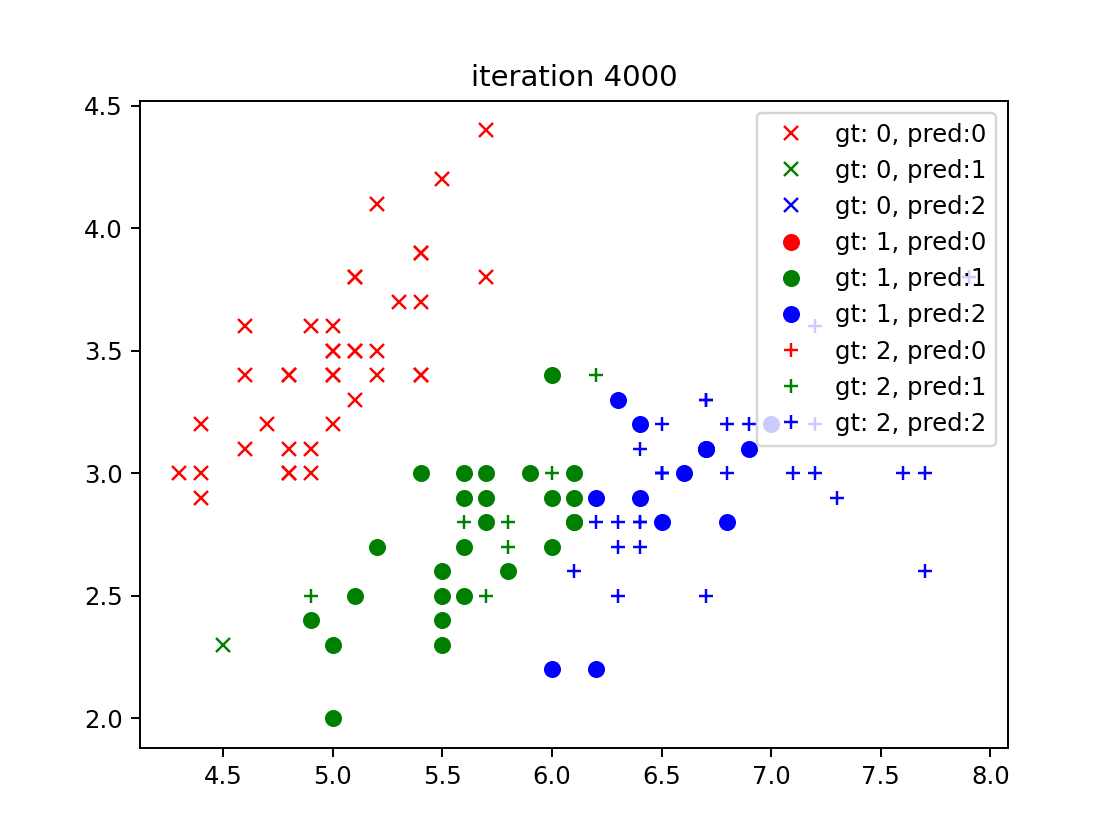

loss at iteration 4500 : 51.51764104099647
loss at iteration 5000 : 51.26540278448775
loss at iteration 5500 : 51.05686216155193
loss at iteration 6000 : 50.88137868212172


<IPython.core.display.Javascript object>


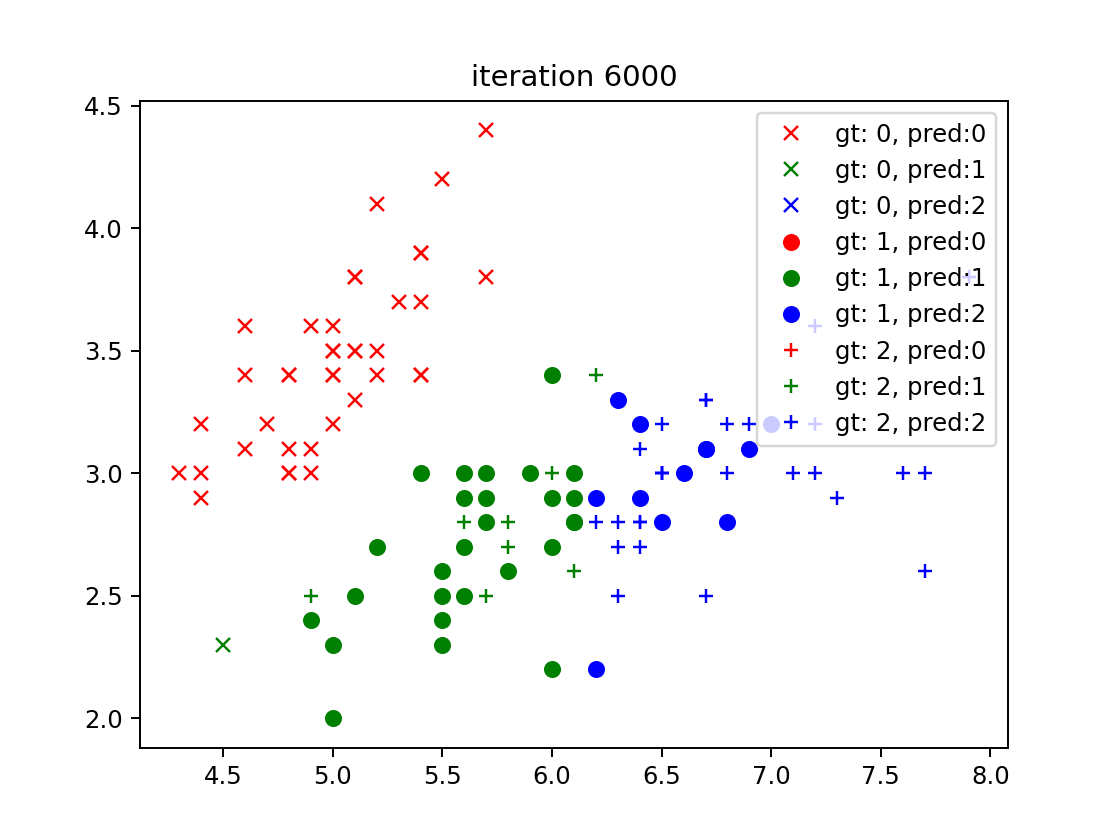

loss at iteration 6500 : 50.73128713866767
loss at iteration 7000 : 50.60096349795215
loss at iteration 7500 : 50.486216854394435
loss at iteration 8000 : 50.3838821880404


<IPython.core.display.Javascript object>


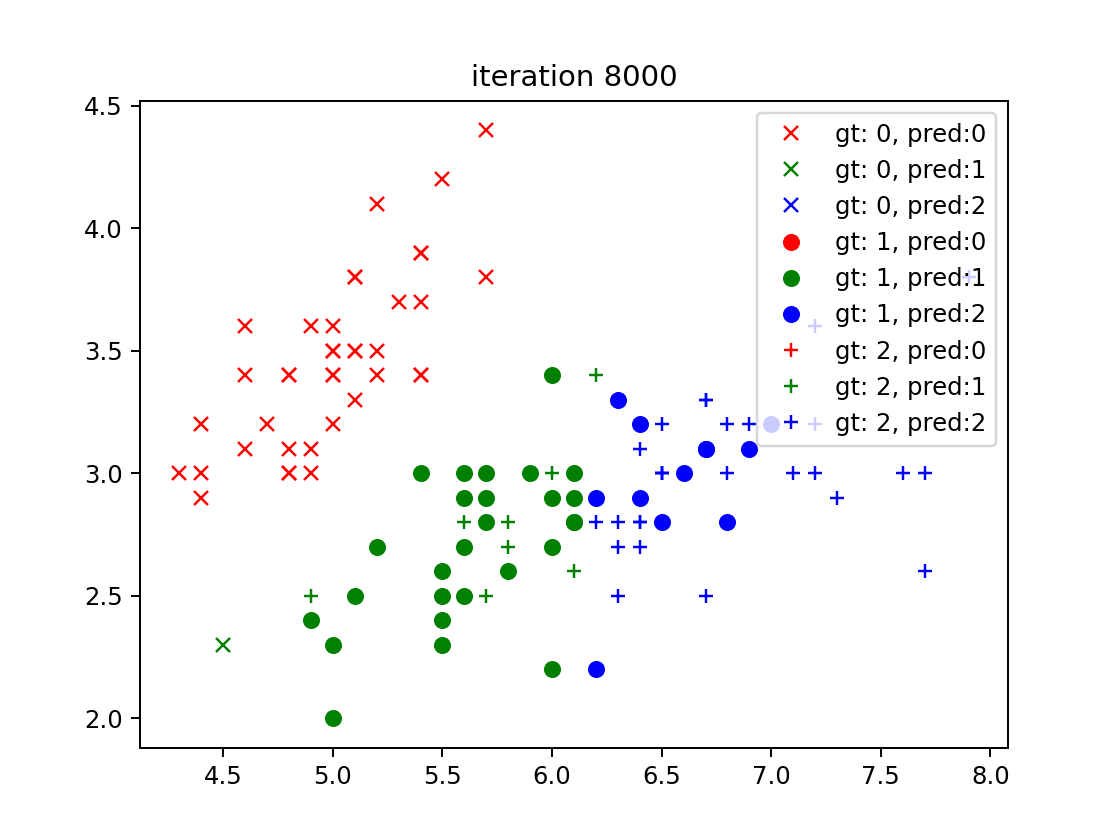

loss at iteration 8500 : 50.291541074571015
loss at iteration 9000 : 50.207326258019584
loss at iteration 9500 : 50.12978251486377
loss at iteration 10000 : 50.05776608489568


<IPython.core.display.Javascript object>


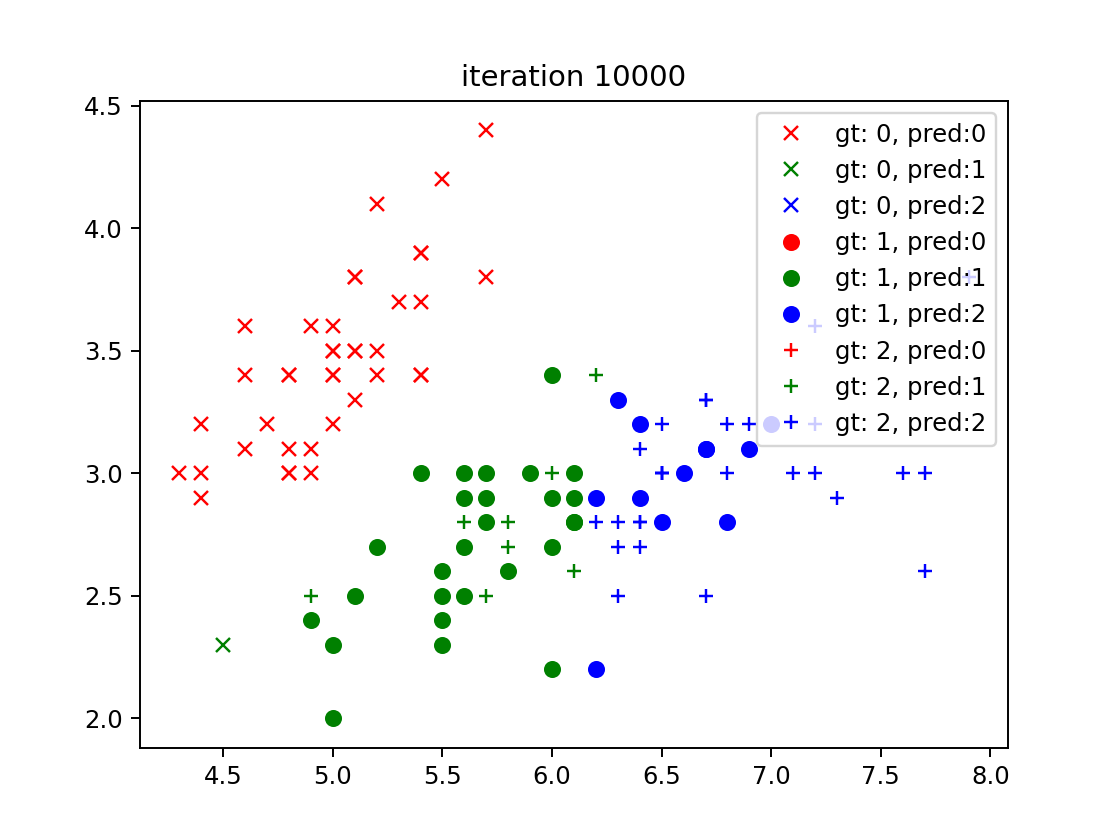

loss at iteration 10500 : 49.99037100134888
loss at iteration 11000 : 49.92687448009973
loss at iteration 11500 : 49.86669600319385
loss at iteration 12000 : 49.809366366150634


<IPython.core.display.Javascript object>


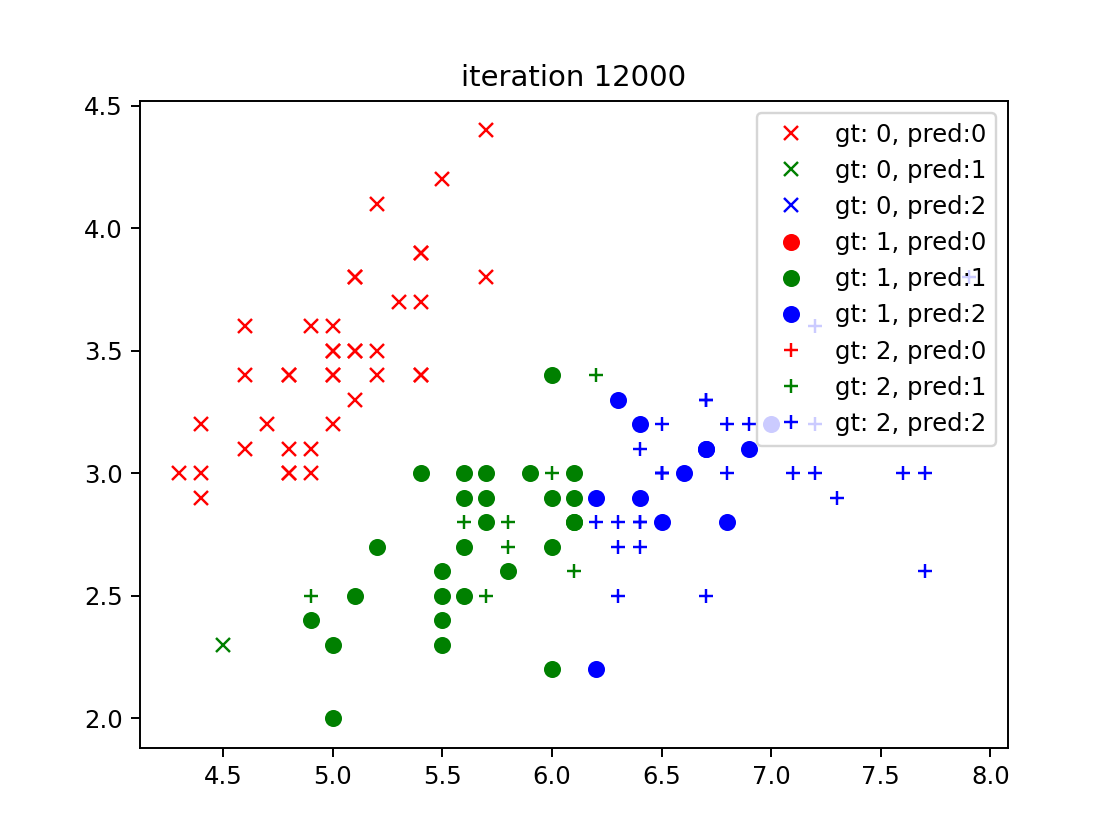

loss at iteration 12500 : 49.75450405713622
loss at iteration 13000 : 49.701797086845175
loss at iteration 13500 : 49.65098890853749
loss at iteration 14000 : 49.60186743356047


<IPython.core.display.Javascript object>


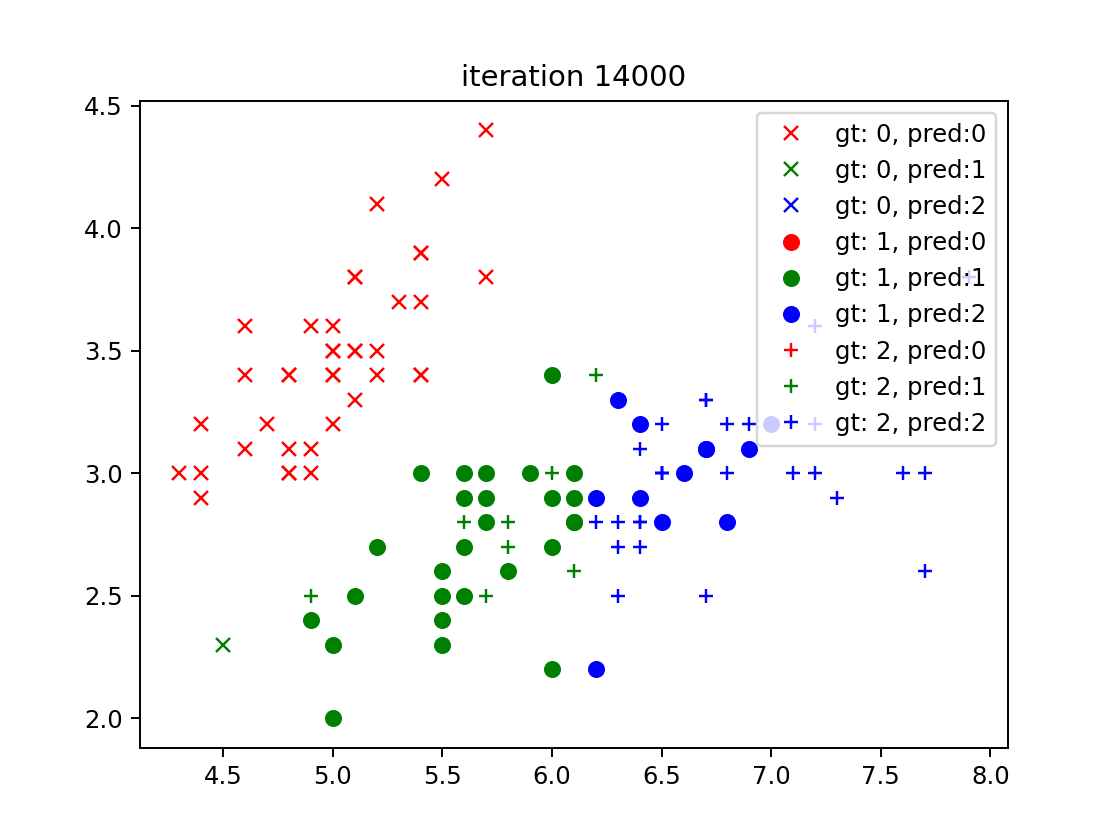

loss at iteration 14500 : 49.55425640797961
loss at iteration 15000 : 49.50800860319328
loss at iteration 15500 : 49.4630004095165
loss at iteration 16000 : 49.41912752158137


<IPython.core.display.Javascript object>


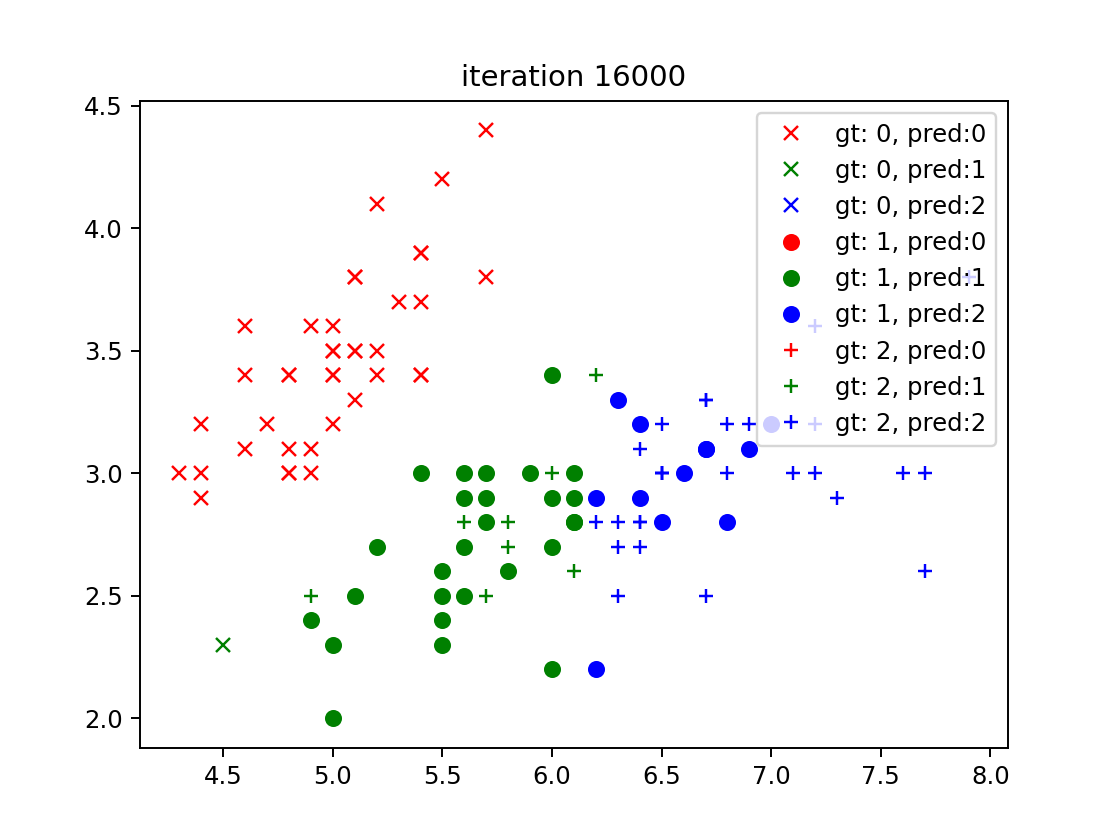

loss at iteration 16500 : 49.37630147832978
loss at iteration 17000 : 49.33444687553592
loss at iteration 17500 : 49.29349911027717
loss at iteration 18000 : 49.25340254817803


<IPython.core.display.Javascript object>


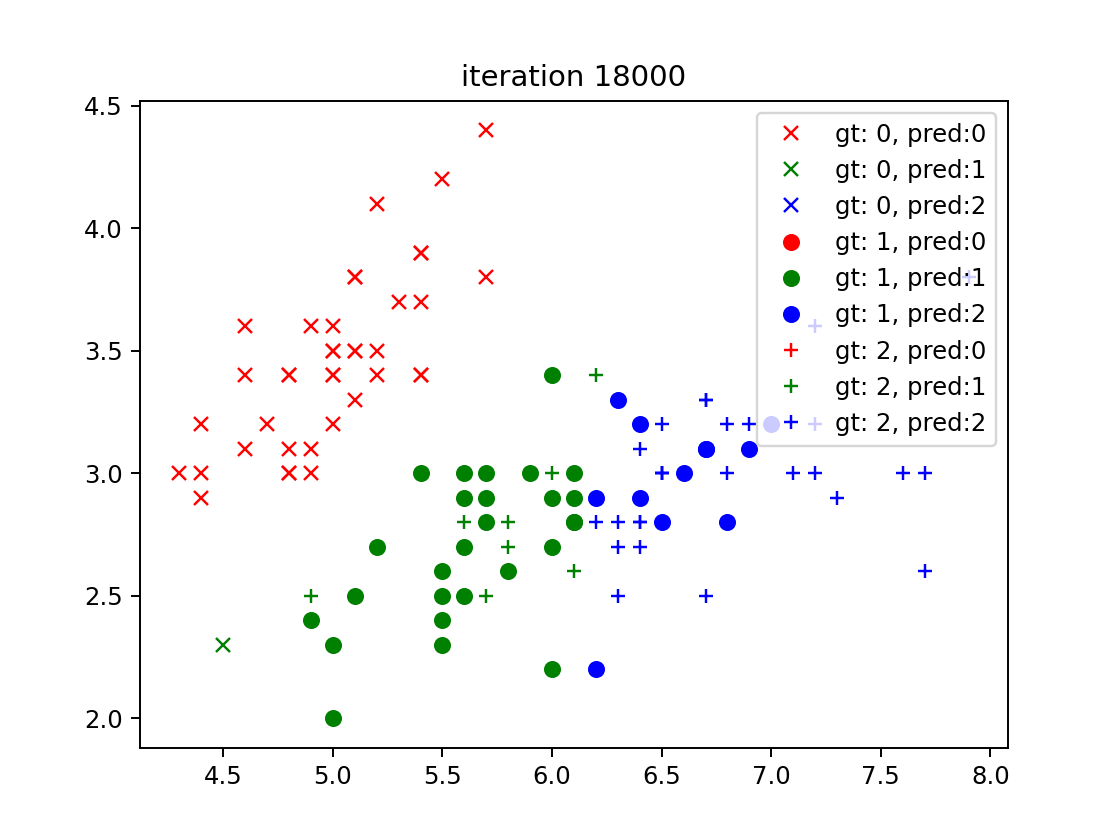

loss at iteration 18500 : 49.21410902818708
loss at iteration 19000 : 49.175576638002795
loss at iteration 19500 : 49.13776870741617


..\hw_05\helpers.py:183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, _ = plt.subplots(1, 1)


<IPython.core.display.Javascript object>


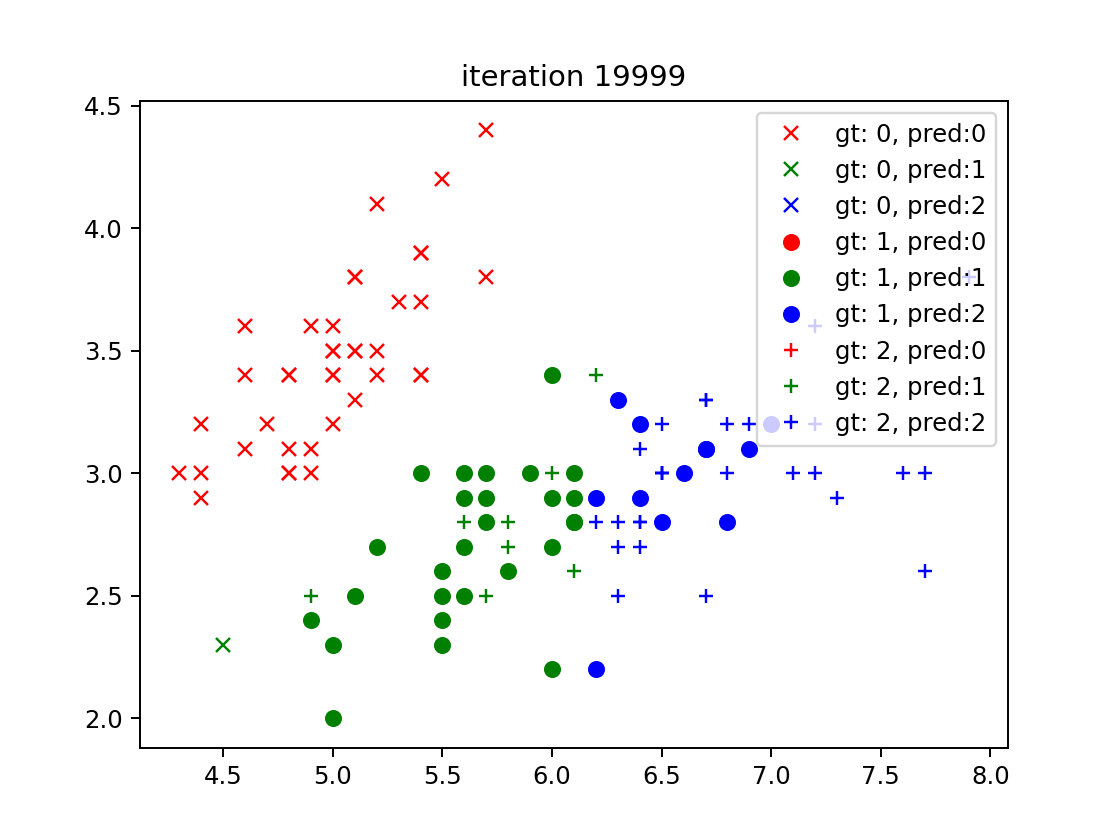

In [27]:
weights_multi = logistic_regression_train_multi(data_train, labels_train, max_iters=20000, lr=1e-3, print_period=500, plot_period=2000)

Accuracy is 0.8333333333333334


..\hw_05\helpers.py:183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, _ = plt.subplots(1, 1)


<IPython.core.display.Javascript object>


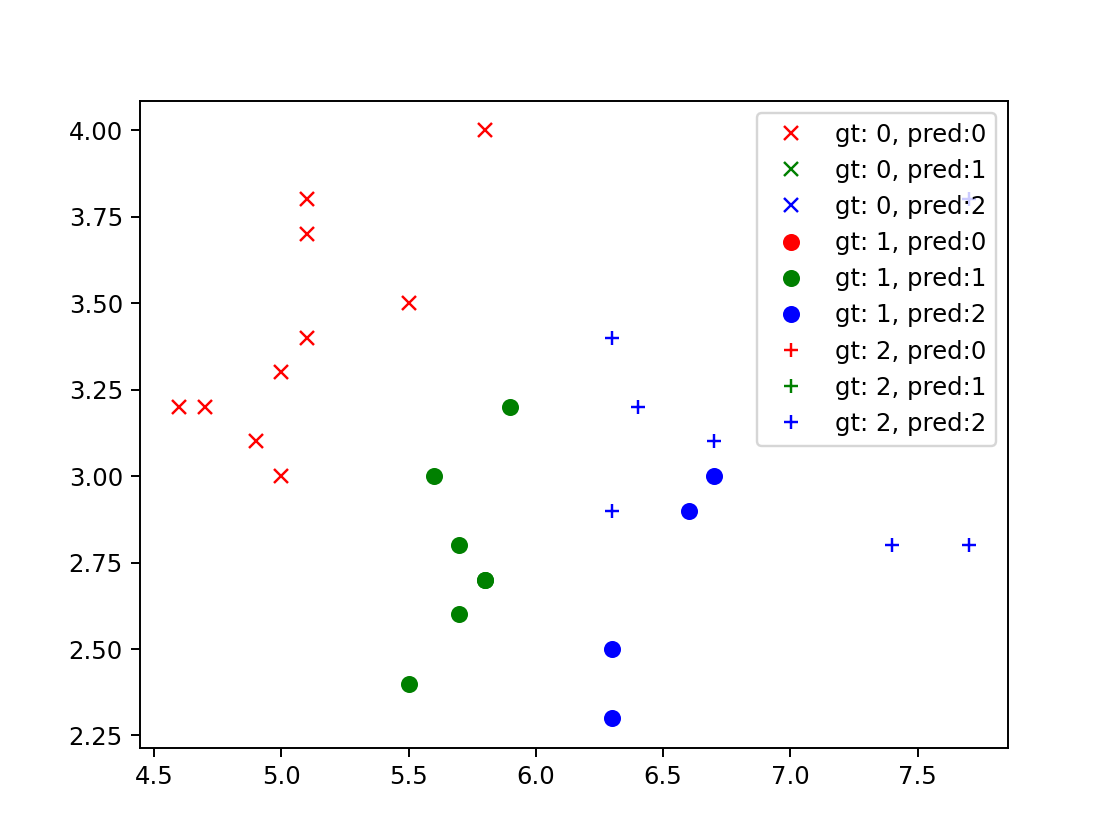

In [28]:
predictions_multi = logistic_regression_classify_multi(data_test, weights_multi)
print("Accuracy is", accuracy(helpers.onehot_to_label(labels_test), predictions_multi))

fig = helpers.visualize_predictions(data=data_test, labels_gt=helpers.onehot_to_label(labels_test), labels_pred=predictions_multi)

 **Q: Comment on the accuracy. What is the difference between the synthetic dataset and this one?**